## Data Processing and EDA

### data import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import welch

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

It contains the following 8 variables:

**Invoice**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. **If this code starts with letter 'c', it indicates a cancellation.**  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**Price**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

In [ ]:
# import dataset
file_path = "online_retail_II.xlsx"
df_2009 = pd.read_excel(file_path, sheet_name="Year 2009-2010")
df_2010 = pd.read_excel(file_path, sheet_name="Year 2010-2011")

In [ ]:
df_full = pd.concat([df_2009, df_2010], ignore_index=True)
print(f"Raw merged shape: {df_full.shape}")

Raw merged shape: (1067371, 8)


### check missing value & transaction overview

In [ ]:
# Check each column's type and missing value
df_full['InvoiceDate'] = pd.to_datetime(df_full['InvoiceDate'])
# View column types and missing values
tab_info = pd.concat([
    pd.DataFrame(df_full.dtypes, columns=['column type']).T,
    pd.DataFrame(df_full.isnull().sum(), columns=['null count']).T,
    pd.DataFrame(df_full.isnull().mean() * 100, columns=['null (%)']).T
])
display(tab_info)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null count,0,0,4382,0,0,0,243007,0
null (%),0.0,0.0,0.410541,0.0,0.0,0.0,22.766873,0.0


In [ ]:
# Count number of unique products, transactions, and customers
summary_stats = {
    'products': df_full['StockCode'].nunique(),
    'transactions': df_full['Invoice'].nunique(),
    'customers': df_full['Customer ID'].nunique()
}

summary_df = pd.DataFrame([summary_stats], index=['count'])
print(summary_df)

# Compute number of products per transaction (i.e., per basket)
# Each (Customer ID, Invoice) pair is treated as one basket
basket_df = df_full.groupby(['Customer ID', 'Invoice'])['InvoiceDate'].count().reset_index()
basket_df.rename(columns={'InvoiceDate': 'Number of products'}, inplace=True)

# Show first 10 baskets sorted by Customer ID
print(basket_df.sort_values('Customer ID').head(10))

       products  transactions  customers
count      5305         53628       5942
    Customer ID  Invoice  Number of products
0       12346.0   491725                   1
16      12346.0  C541433                   1
15      12346.0  C525274                   1
14      12346.0  C525099                   1
13      12346.0  C514024                  10
12      12346.0  C495800                   1
11      12346.0   541431                   1
10      12346.0   513774                  19
9       12346.0   499763                   5
7       12346.0   494450                   1


Among all retail records, there are 5305 types of products, and 53628 transactions from 5942 customers. Notice that there are cancellation orders that begin with a 'C' in Invoice column.

### check cancellation orders

In [ ]:
# Identify all cancelled transactions: those with Invoice starting with 'C'
cancelled = df_full[df_full['Invoice'].astype(str).str.startswith('C')]

# Display number and sample of cancelled entries
print(f"Number of cancelled records: {len(cancelled)}")

# For matching original (non-cancelled) orders, extract their counterparts
non_cancelled = df_full[~df_full['Invoice'].astype(str).str.startswith('C')]

# Try to find, for each cancellation, a matching original purchase:
# same Customer ID, StockCode, Price, and opposite Quantity
merged = pd.merge(
    cancelled,
    non_cancelled,
    on=['Customer ID', 'StockCode', 'Price'],
    suffixes=('_cancel', '_orig')
)

# Check if quantities match (cancelled quantity should be negative of original)
matched = merged[merged['Quantity_cancel'] == -merged['Quantity_orig']]
print(matched.head())
print(f"Number of cancellations with exact matching original: {len(matched)}")

Number of cancelled records: 19494
  Invoice_cancel StockCode             Description_cancel  Quantity_cancel  \
0        C489449     22087       PAPER BUNTING WHITE LACE              -12   
4        C489449    85206A   CREAM FELT EASTER EGG BASKET               -6   
6        C489449     21895  POTTING SHED SOW 'N' GROW SET               -4   
7        C489449     21896             POTTING SHED TWINE               -6   
8        C489449     22083     PAPER CHAIN KIT RETRO SPOT              -12   

   InvoiceDate_cancel  Price  Customer ID Country_cancel Invoice_orig  \
0 2009-12-01 10:33:00   2.95      16321.0      Australia       489450   
4 2009-12-01 10:33:00   1.65      16321.0      Australia       489450   
6 2009-12-01 10:33:00   4.25      16321.0      Australia       489450   
7 2009-12-01 10:33:00   2.10      16321.0      Australia       489450   
8 2009-12-01 10:33:00   2.95      16321.0      Australia       489450   

                Description_orig  Quantity_orig    Invoic

As see from the matched table (cancelled + original transaction record), when an order is canceled, there should be another order in the dataframe, with identical column values except for the **Quantity** and **InvoiceDate** variables.

But it turns out that Number of cancellations with exact matching original (15715) is different from Number of cancelled records (19494), maybe due to missing values or input errors -- it's very hard to fix this issue.

For the matched canceled and original order pairs, we remove them.

In [ ]:
cancel_invoices = matched['Invoice_cancel']
original_invoices = matched['Invoice_orig']

print(f"Original size: {len(df_full)}")
df_full = df_full[
    ~df_full['Invoice'].isin(cancel_invoices) &
    ~df_full['Invoice'].isin(original_invoices)
]
print(f"After removing matched cancel-original pairs: {len(df_full)}")

Original size: 1067371
After removing matched cancel-original pairs: 775529


### remove missing and other values we don't want

In [ ]:
# keep positive quantity and price
df_full = df_full[(df_full['Quantity'] > 0) & (df_full['Price'] > 0)]
# Create new feature: total sales
df_full['Sales'] = df_full['Quantity'] * df_full['Price']
print(f"After removing nagative quantity and price: {len(df_full)}")
print(df_full.head())

After removing nagative quantity and price: 760549
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Sales  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom   83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom   81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom   81.0  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  100.8  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom   30.0  


In [ ]:
# Now we have an overview of the dataset
# Next we want to categorize the product, so we repair product-only clean version:
# process the description format, and drop customer ID column (we don't need it for categorization).
df_cleaned = df_full.copy()
df_cleaned.dropna(subset=['Description'], inplace=True)
df_cleaned = df_cleaned[~df_cleaned['Description'].str.contains(r'[\?\*\!@#\$%\^\&]', na=False)]
df_cleaned = df_cleaned[~df_cleaned['Description'].str.lower().isin(['mixed up', 'lost'])]
df_cleaned.drop('Customer ID', axis=1, inplace=True)

print(f"Product-only clean version shape: {df_cleaned.shape}")
print(df_cleaned.head())

Product-only clean version shape: (756492, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price         Country  Sales  
0 2009-12-01 07:45:00   6.95  United Kingdom   83.4  
1 2009-12-01 07:45:00   6.75  United Kingdom   81.0  
2 2009-12-01 07:45:00   6.75  United Kingdom   81.0  
3 2009-12-01 07:45:00   2.10  United Kingdom  100.8  
4 2009-12-01 07:45:00   1.25  United Kingdom   30.0  


In [ ]:
print("Quantity, Unit Price, and Sales statistics:")
df_cleaned[['Quantity','Price','Sales']].describe().T

Quantity, Unit Price, and Sales statistics:


,count,mean,std,min,25%,50%,75%,max
Quantity,756492.0,11.430718,66.722822,1.000,1.00,4.00,12.00,12960.00
Price,756492.0,3.782350,42.985511,0.001,1.25,2.08,4.13,25111.09
Sales,756492.0,20.727529,91.631140,0.001,4.16,10.20,17.85,38970.00


In [ ]:
# View column types and missing values
tab_info = pd.concat([
    pd.DataFrame(df_cleaned.dtypes, columns=['column type']).T,
    pd.DataFrame(df_cleaned.isnull().sum(), columns=['null count']).T,
    pd.DataFrame(df_cleaned.isnull().mean() * 100, columns=['null (%)']).T
])
display(tab_info)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales
column type,object,object,object,int64,datetime64[ns],float64,object,float64
null count,0,0,0,0,0,0,0,0
null (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
summary_cleaned_stats = {
    'products': df_cleaned['StockCode'].nunique(),
    'transactions': df_cleaned['Invoice'].nunique(),
}

summary_cleaned_df = pd.DataFrame([summary_cleaned_stats], index=['count'])
print(summary_cleaned_df)

       products  transactions
count      4823         33424


### special symbol on StockCode

Notice that there are lots of special symbols in StockCode and Description columns that do not refer to real product information, and we need to detect these values and remove them.

In [ ]:
# generally, normal stock code are pure numbers, so we first extract stock code that contains letters
df_cleaned['StockCode'] = df_cleaned['StockCode'].astype(str)
regex_mask = df_cleaned['StockCode'].str.contains(r'[a-zA-Z]', na=False, regex=True)
candidate_df = df_cleaned[regex_mask]
code_summary = (
    candidate_df
    .groupby('StockCode')
    .agg(Frequency=('StockCode', 'count'), Example_Description=('Description', 'first'))
    .sort_values(by='Frequency', ascending=False)
)
print(code_summary)
code_summary.to_csv('suspect_stockcodes.csv', index=True)

           Frequency                 Example_Description
StockCode                                               
85123A          4369  WHITE HANGING HEART T-LIGHT HOLDER
85099B          3121         JUMBO BAG RED WHITE SPOTTY 
POST            1470                             POSTAGE
85099C          1437      JUMBO  BAG BAROQUE BLACK WHITE
82494L          1425         WOODEN FRAME ANTIQUE WHITE 
...              ...                                 ...
62097B             1           BLUE STRIPES SHOULDER BAG
71434B             1    BLACK RND BULLET"KEEP CLEAN" BIN
90183c             1    BLACK DROP EARRINGS W LONG BEADS
72084B             1          CHOCOLATE ICE CREAM CANDLE
84510b             1      SET OF 4 FAIRY CAKES COASTERS 

[1486 rows x 2 columns]


In [ ]:
# after reviewing 'suspect_stockcodes_with_descriptions.csv', we found that:
# StockCode like 85099B or 15056BL refer to valid product but not special symbols,
# so we remove these codes from suspect list.

# ==== there are SPECIAL CASES, we'll deal with those later ====

import re
# Keep only those suspect codes NOT matching the pattern: number(s) + 1–2 letter suffix
def is_purely_suspect(code):
    return not re.fullmatch(r'\d+[a-zA-Z]{1,2}$', code)
# Filter out such normal alphanumeric product codes
filtered_codes = code_summary[code_summary.index.map(is_purely_suspect)]
print(filtered_codes)

# Export filtered version
filtered_codes.to_csv('filtered_suspect_stockcodes.csv', index=True)

              Frequency                  Example_Description
StockCode                                                   
POST               1470                              POSTAGE
DOT                 963                       DOTCOM POSTAGE
M                   611                               Manual
C2                   84                             CARRIAGE
ADJUST               36  Adjustment by john on 26/01/2010 16
BANK CHARGES         30                         Bank Charges
DCGS0058             16                     MISO PRETTY  GUM
PADS                 14           PADS TO MATCH ALL CUSHIONS
gift_0001_30         12   Dotcomgiftshop Gift Voucher £30.00
gift_0001_20         11   Dotcomgiftshop Gift Voucher £20.00
DCGSSGIRL            11                      GIRLS PARTY BAG
DCGS0076             10         SUNJAR LED NIGHT NIGHT LIGHT
TEST001               9              This is a test product.
gift_0001_10          8   Dotcomgiftshop Gift Voucher £10.00
DCGS0003              6 

In [ ]:
# when we manually review the code again, we found that:
# stockcode starting with DCGS like DCGS0058, DCGS0003 also refer to valid product and not special symbols,
# so we remove them from suspect list as well.

# Function to identify truly suspect codes
def is_purely_suspect(code):
    # Remove known valid patterns:
    # - Numeric + 1–2 letter suffix (e.g., 84032B)
    # - Codes starting with DCGS
    if re.fullmatch(r'\d+[a-zA-Z]{1,2}$', code):
        return False
    if code.startswith('DCGS'):
        return False
    return True
# Apply updated filter
final_suspect_codes = code_summary[code_summary.index.map(is_purely_suspect)]
print(final_suspect_codes)

# Export result
final_suspect_codes.to_csv('filtered_suspect_stockcodes.csv', index=True)

              Frequency                  Example_Description
StockCode                                                   
POST               1470                              POSTAGE
DOT                 963                       DOTCOM POSTAGE
M                   611                               Manual
C2                   84                             CARRIAGE
ADJUST               36  Adjustment by john on 26/01/2010 16
BANK CHARGES         30                         Bank Charges
PADS                 14           PADS TO MATCH ALL CUSHIONS
gift_0001_30         12   Dotcomgiftshop Gift Voucher £30.00
gift_0001_20         11   Dotcomgiftshop Gift Voucher £20.00
TEST001               9              This is a test product.
gift_0001_10          8   Dotcomgiftshop Gift Voucher £10.00
m                     5                               Manual
D                     4                             Discount
gift_0001_50          4   Dotcomgiftshop Gift Voucher £50.00
ADJUST2               3 

In [ ]:
# remove rows with confirmed special StockCodes
final_suspect_codes_list = [
    'POST', 'DOT', 'M', 'C2', 'ADJUST', 'BANK CHARGES', 'PADS',
    'gift_0001_30', 'gift_0001_20', 'TEST001', 'gift_0001_10',
    'm', 'D', 'gift_0001_50', 'ADJUST2', 'gift_0001_40',
    'gift_0001_70', 'TEST002', 'B'
]

df_cleaned = df_cleaned[~df_cleaned['StockCode'].isin(final_suspect_codes_list)]

### special symbol on Description

there are still some special cases in the description column, we also need to detect them

In [ ]:
# Step 1: define suspect patterns
suspect_keywords = [
    r'\?', 'manual', 'test', 'adjust', 'carriage',
    'charges', 'dotcom', 'bank', 'postage', 'gift',
    'wet', 'damages', 'lost', 'missing', 'mix', 'check', 'rusty',
    'found', 'incorrect', 'error', 'reject', 'exchange', 'return',
    'debt', 'cancel', 'fault', 'broken', 'crushed', 'no sale',
    'sample', 'mismatch', 'problem', 'unwanted', 'fee'
]
pattern = '|'.join(suspect_keywords)

# Step 2: filter rows with suspect descriptions
suspect_desc_df = df_cleaned[
    df_cleaned['Description'].str.lower().str.contains(pattern, regex=True, na=False)
]

# Step 3: group by StockCode + Description and count
desc_summary = (
    suspect_desc_df
    .groupby(['StockCode', 'Description'])
    .size()
    .reset_index(name='Frequency')
    .sort_values(by='Frequency', ascending=False)
)

# Step 4: export for manual screening
desc_summary.to_csv('suspect_descriptions.csv', index=False)

In [ ]:
# After manual review, it seems that only description with name "Next Day Carriage" is a special case
# Remove all rows where Description is "Next Day Carriage" (case-insensitive just in case)
df_cleaned = df_cleaned[~df_cleaned['Description'].str.lower().eq('next day carriage')]

In [ ]:
df_cleaned.to_csv('cleaned_retail_dataset.csv', index=False)
# df_cleaned.to_excel('cleaned_retail_dataset.xlsx', index=False)

In [ ]:
df_cleaned.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,30.0


### EDA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/Online Retail

/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail


In [5]:
df_cleaned = pd.read_csv('cleaned_retail_dataset.csv')
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753156 entries, 0 to 753155
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      753156 non-null  int64         
 1   StockCode    753156 non-null  object        
 2   Description  753156 non-null  object        
 3   Quantity     753156 non-null  int64         
 4   InvoiceDate  753156 non-null  datetime64[ns]
 5   Price        753156 non-null  float64       
 6   Country      753156 non-null  object        
 7   Sales        753156 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 46.0+ MB


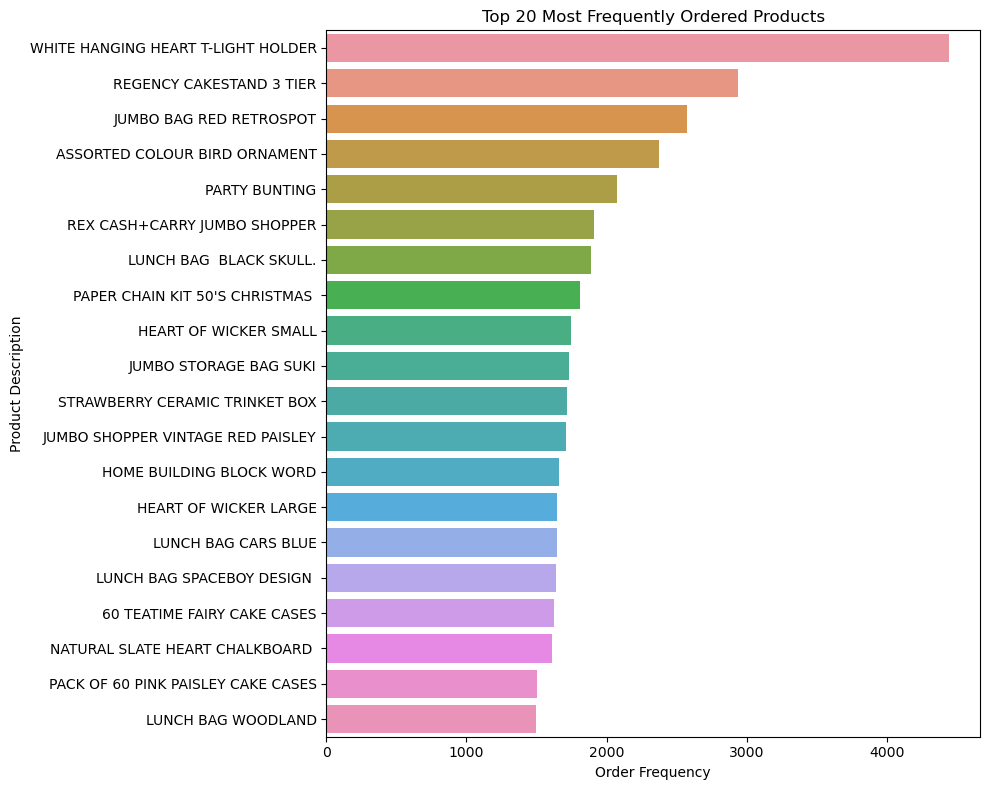

In [ ]:
top_products = (
    df_cleaned['Description']
    .value_counts()
    .head(20)
    .reset_index()
)
top_products.columns = ['Description', 'Frequency']

plt.figure(figsize=(10, 8))
sns.barplot(data=top_products, x='Frequency', y='Description')
plt.title('Top 20 Most Frequently Ordered Products')
plt.xlabel('Order Frequency')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

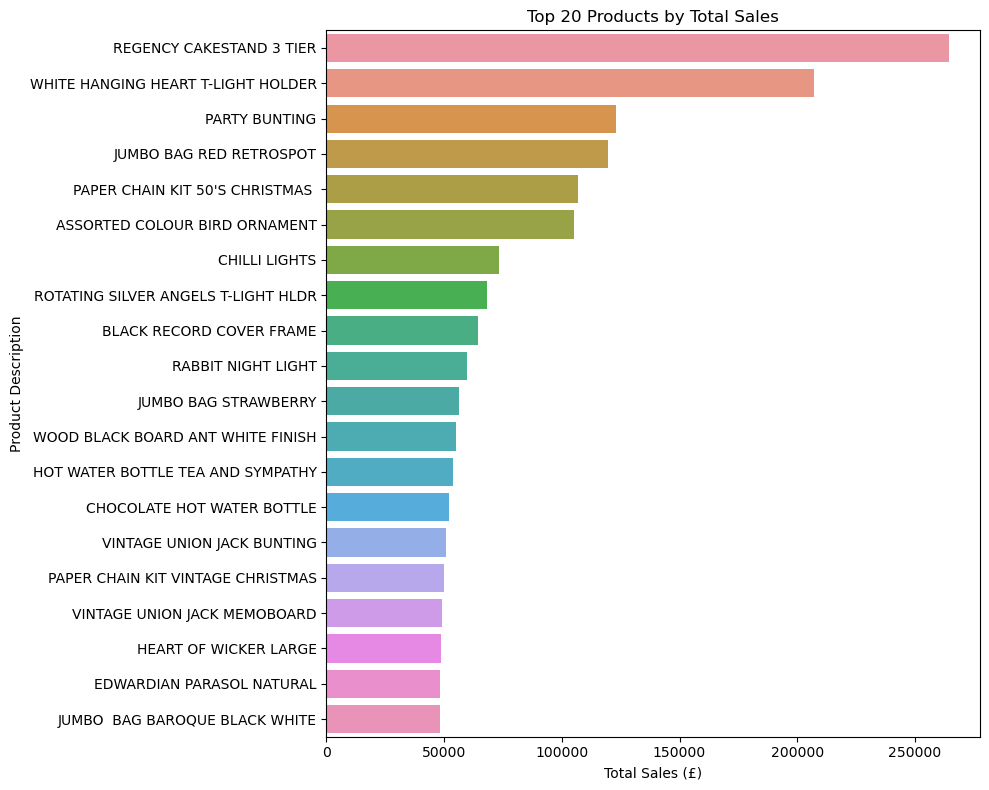

In [ ]:
# Group by Description, sum Sales, sort top 20
product_sales = (
    df_cleaned.groupby('Description')['Sales']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

plt.figure(figsize=(10, 8))
sns.barplot(data=product_sales, x='Sales', y='Description')
plt.title('Top 20 Products by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

count    753156.000000
mean          3.239064
std           4.787790
min           0.030000
25%           1.250000
50%           2.080000
75%           3.950000
max        1157.150000
Name: Price, dtype: float64


/Users/mazhiqi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


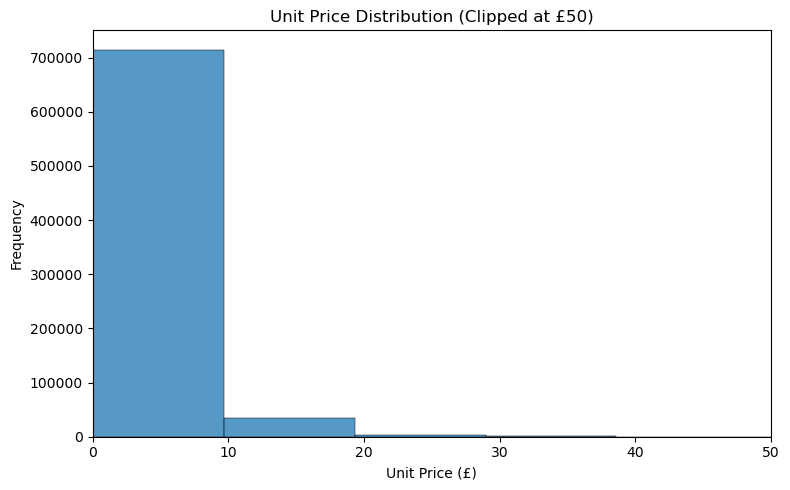

In [ ]:
print(df_cleaned['Price'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['Price'], bins=120)
plt.xlim(0, 50)
plt.title('Unit Price Distribution (Clipped at £50)')
plt.xlabel('Unit Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

/Users/mazhiqi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


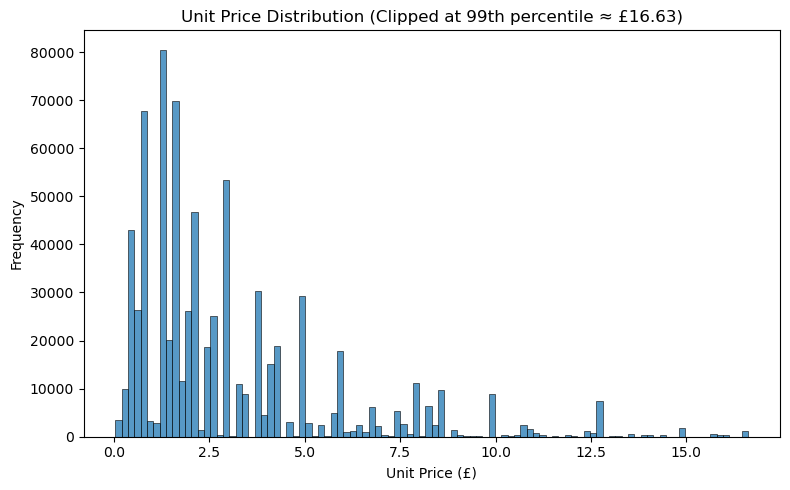

In [ ]:
price_cutoff = df_cleaned['Price'].quantile(0.99)

plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned[df_cleaned['Price'] <= price_cutoff]['Price'], bins=100)
plt.title(f'Unit Price Distribution (Clipped at 99th percentile ≈ £{price_cutoff:.2f})')
plt.xlabel('Unit Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### time series plot

/var/folders/fh/x42m5xbn25d25fy3bskk3jkm0000gn/T/ipykernel_42714/2709481772.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_quantity = df_cleaned.resample('M', on='InvoiceDate')['Quantity'].sum()
/var/folders/fh/x42m5xbn25d25fy3bskk3jkm0000gn/T/ipykernel_42714/2709481772.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_cleaned.resample('M', on='InvoiceDate')['Sales'].sum()


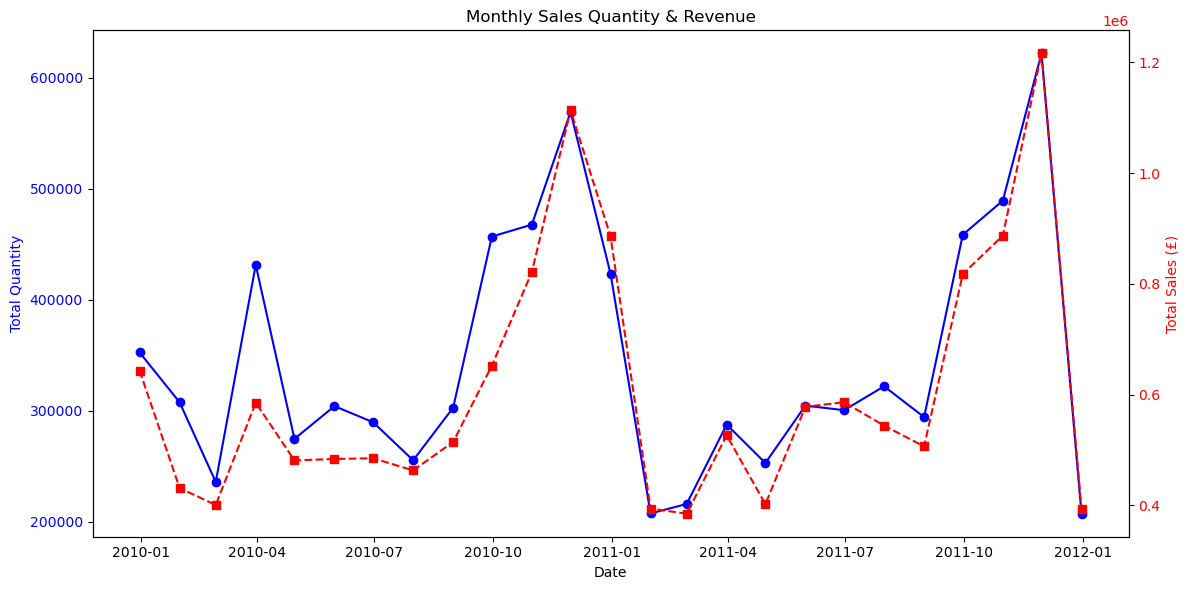

In [ ]:
# === Monthly quantity and sales over time ===
monthly_quantity = df_cleaned.resample('M', on='InvoiceDate')['Quantity'].sum()
monthly_sales = df_cleaned.resample('M', on='InvoiceDate')['Sales'].sum()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(monthly_quantity, marker='o', linestyle='-', color='b', label='Total Quantity')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Quantity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(monthly_sales, marker='s', linestyle='--', color='r', label='Total Sales (£)')
ax2.set_ylabel('Total Sales (£)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Monthly Sales Quantity & Revenue')
fig.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

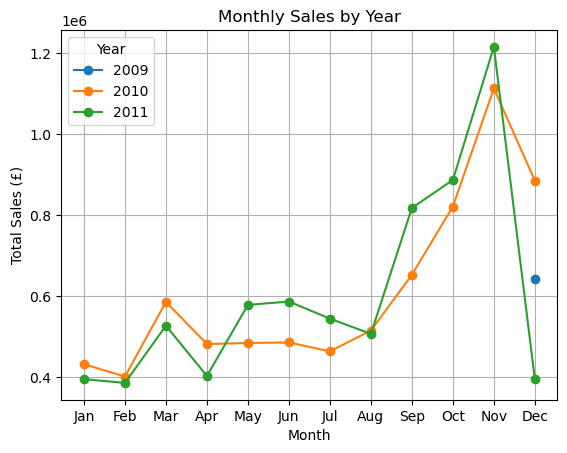

In [ ]:
# === Monthly sales by year ===
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month

monthly_sales_by_year = df_cleaned.groupby(['Year', 'Month'])['Sales'].sum().unstack(level=0)

plt.figure(figsize=(12, 6))
monthly_sales_by_year.plot(marker='o', linestyle='-')
plt.title('Monthly Sales by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

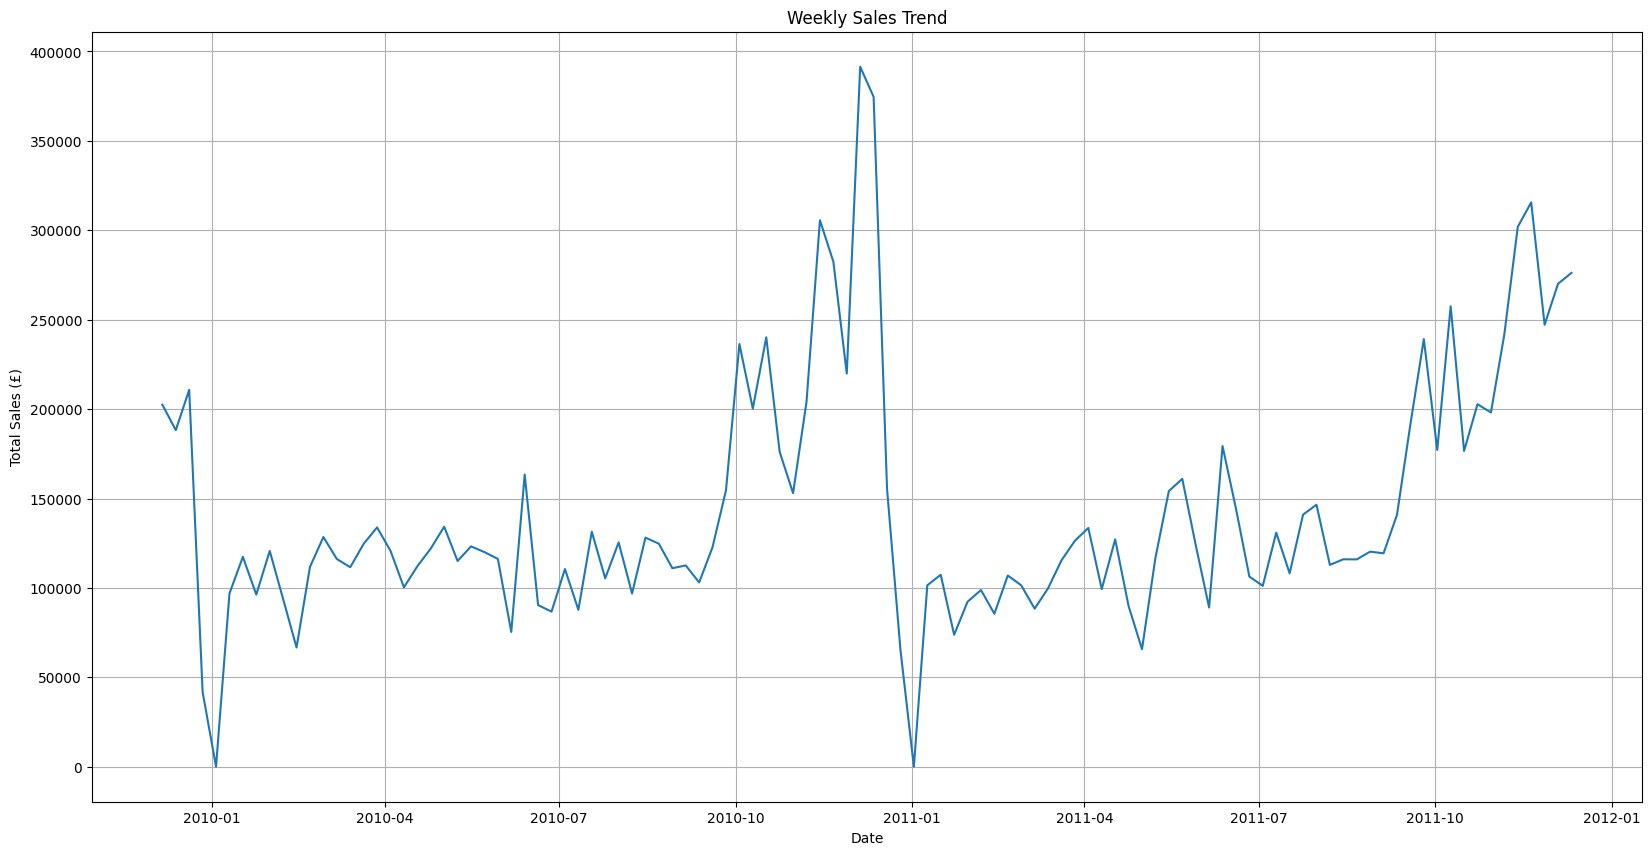

In [16]:
# === Weekly sales trend ===
weekly_sales = df_cleaned.resample('W', on='InvoiceDate')['Sales'].sum()

plt.figure(figsize=(20, 10))
plt.plot(weekly_sales)
plt.title('Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales (£)')
plt.grid(True)
plt.show()

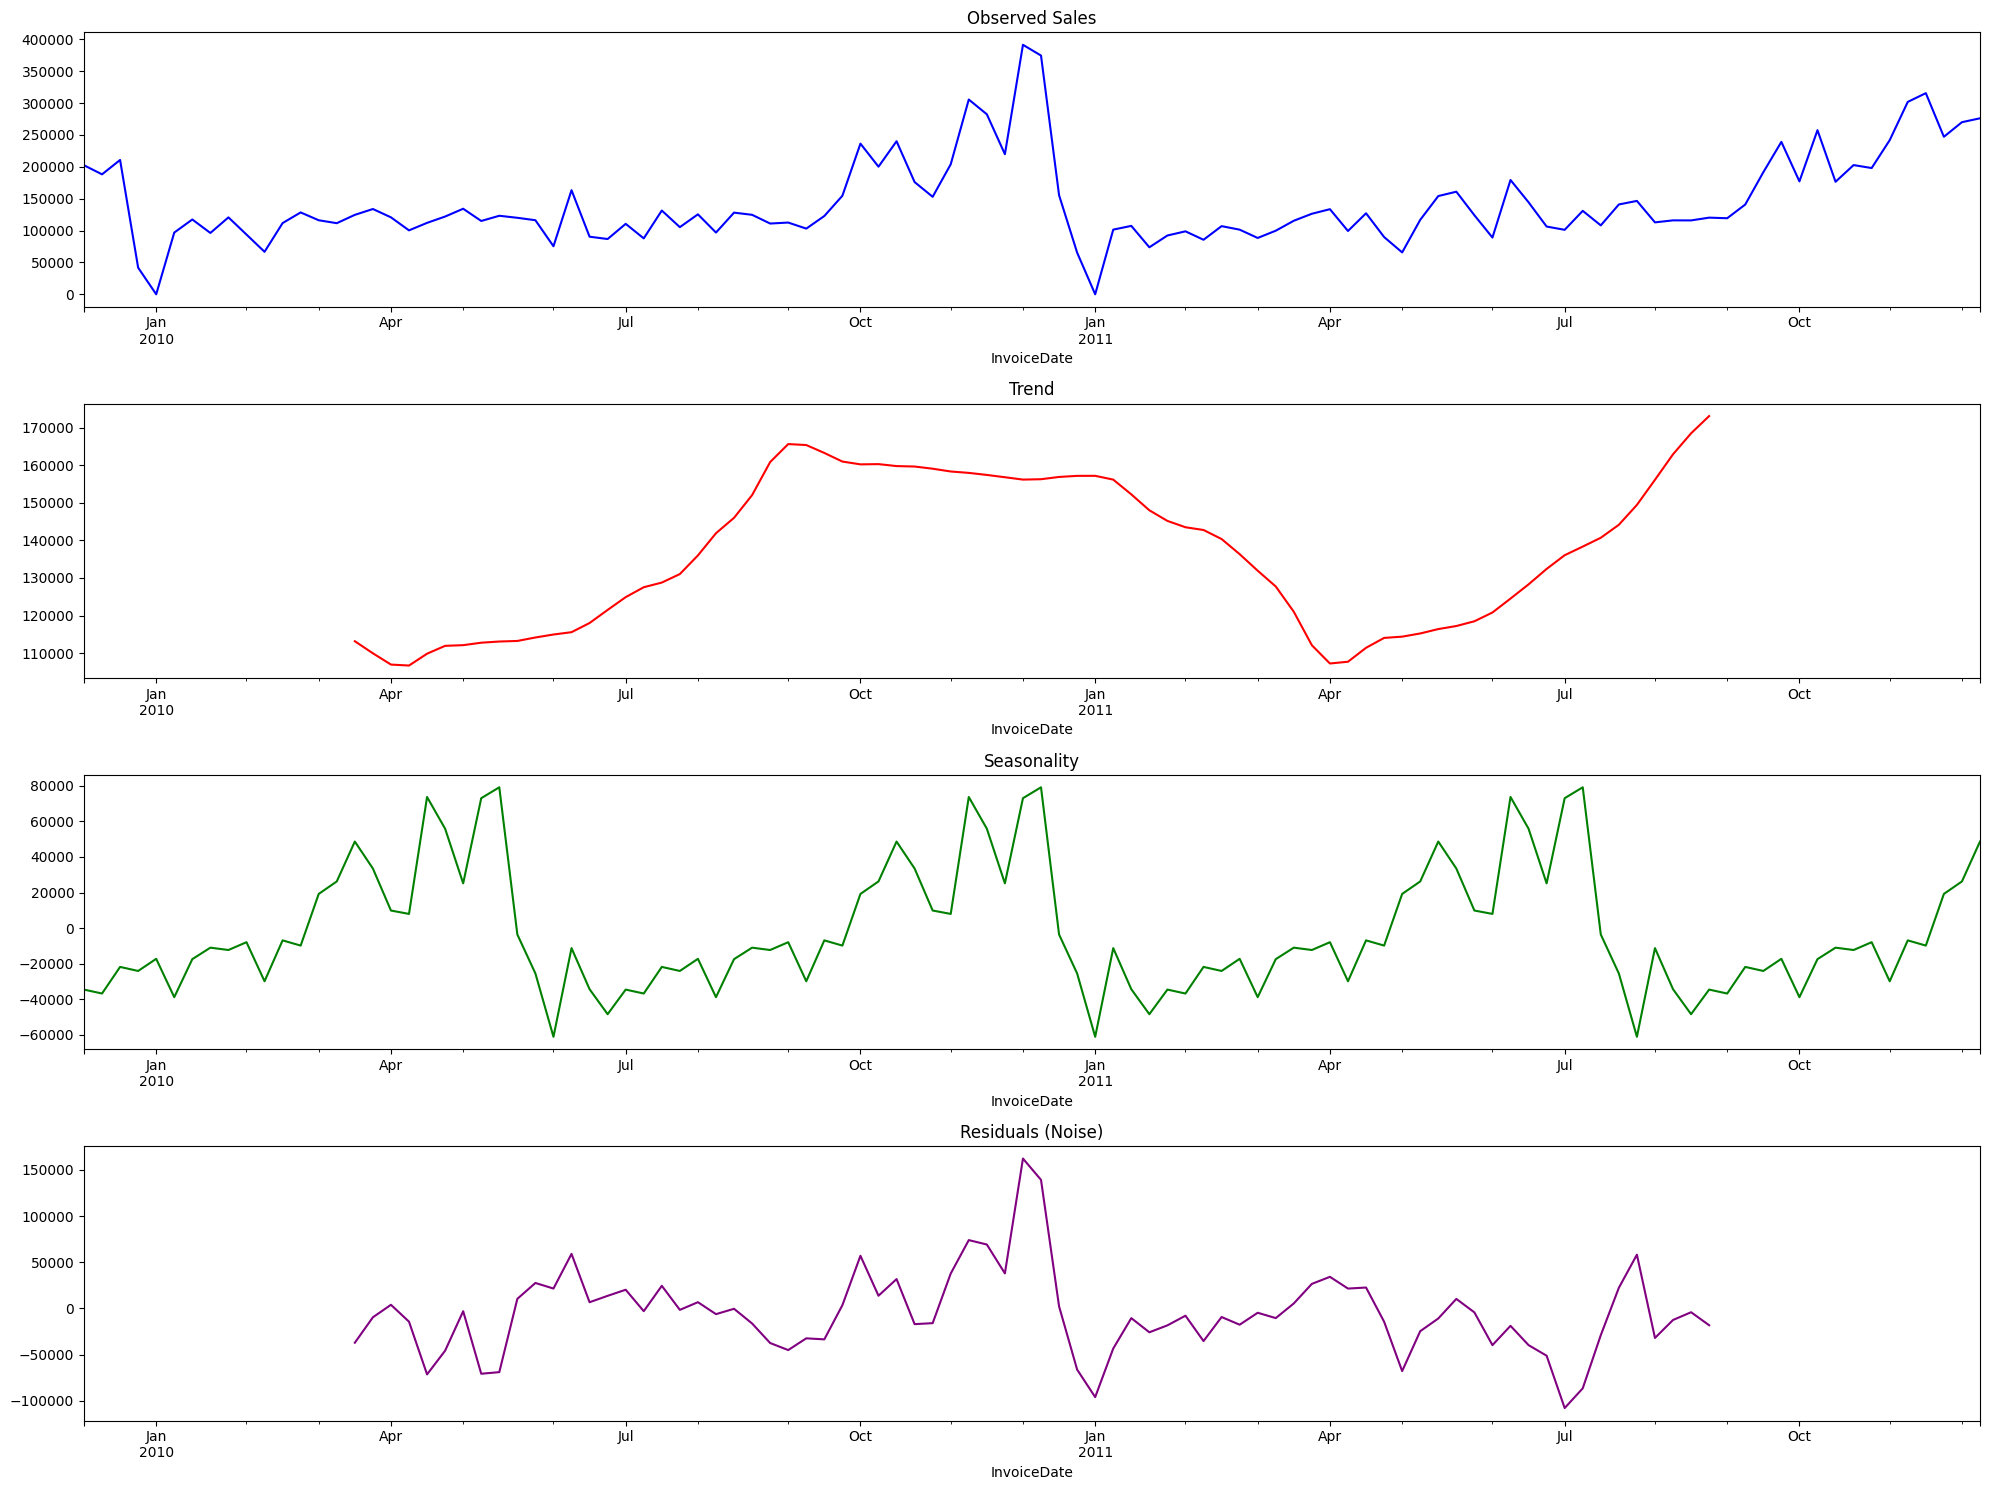

In [8]:
# === Weekly Seasonal decomposition ===
decomposed = seasonal_decompose(weekly_sales, model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(20, 15))
decomposed.observed.plot(ax=axes[0], color='blue', title='Observed Sales')
decomposed.trend.plot(ax=axes[1], color='red', title='Trend')
decomposed.seasonal.plot(ax=axes[2], color='green', title='Seasonality')
decomposed.resid.plot(ax=axes[3], color='purple', title='Residuals (Noise)')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

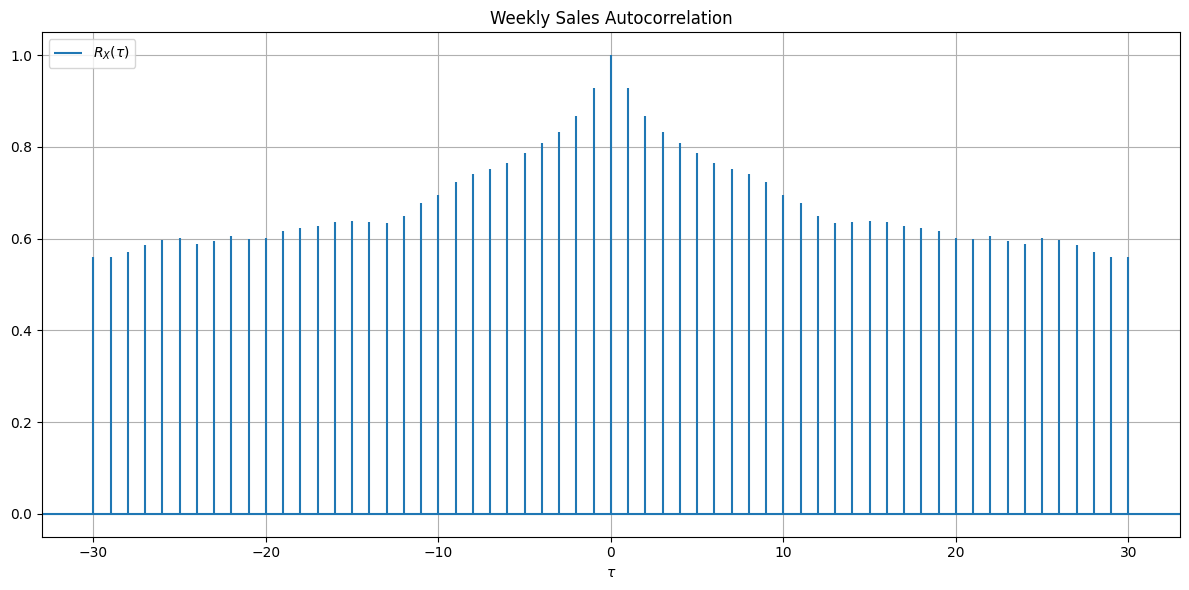

In [10]:
# === Weekly Autocorrelation plot ===
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
ax.acorr(weekly_sales, maxlags=30, usevlines=True, linestyle='solid')
plt.xlabel(r'$\tau$')
plt.legend([r'$R_X(\tau)$'], loc='upper left')
plt.title('Weekly Sales Autocorrelation')
ax.grid(True, which='both')
plt.tight_layout()
plt.show()

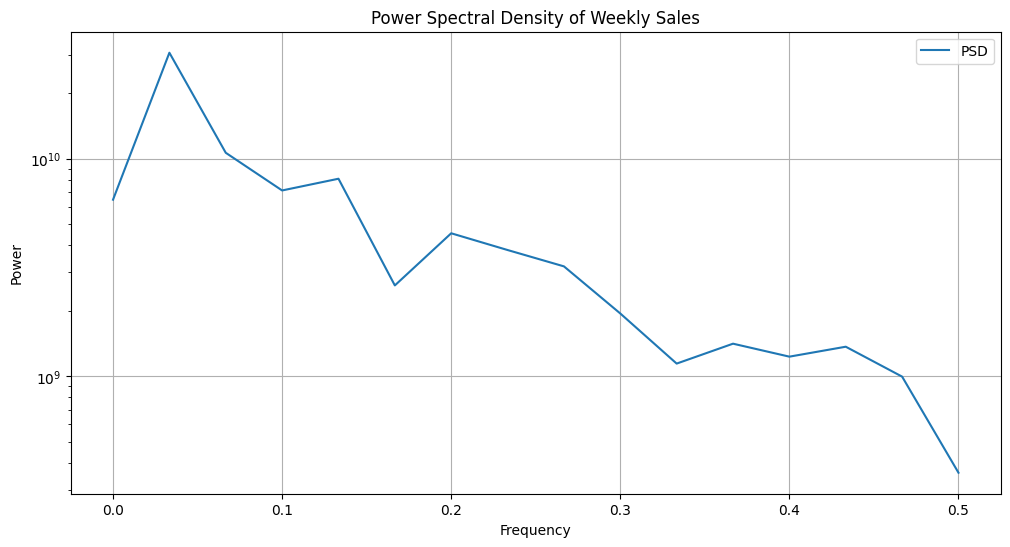

In [11]:
# === Weekly Power Spectral Density ===
freq, psd = welch(weekly_sales.dropna(), nperseg=30)

plt.figure(figsize=(12, 6))
plt.semilogy(freq, psd)
plt.title("Power Spectral Density of Weekly Sales")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.legend(['PSD'])
plt.show()

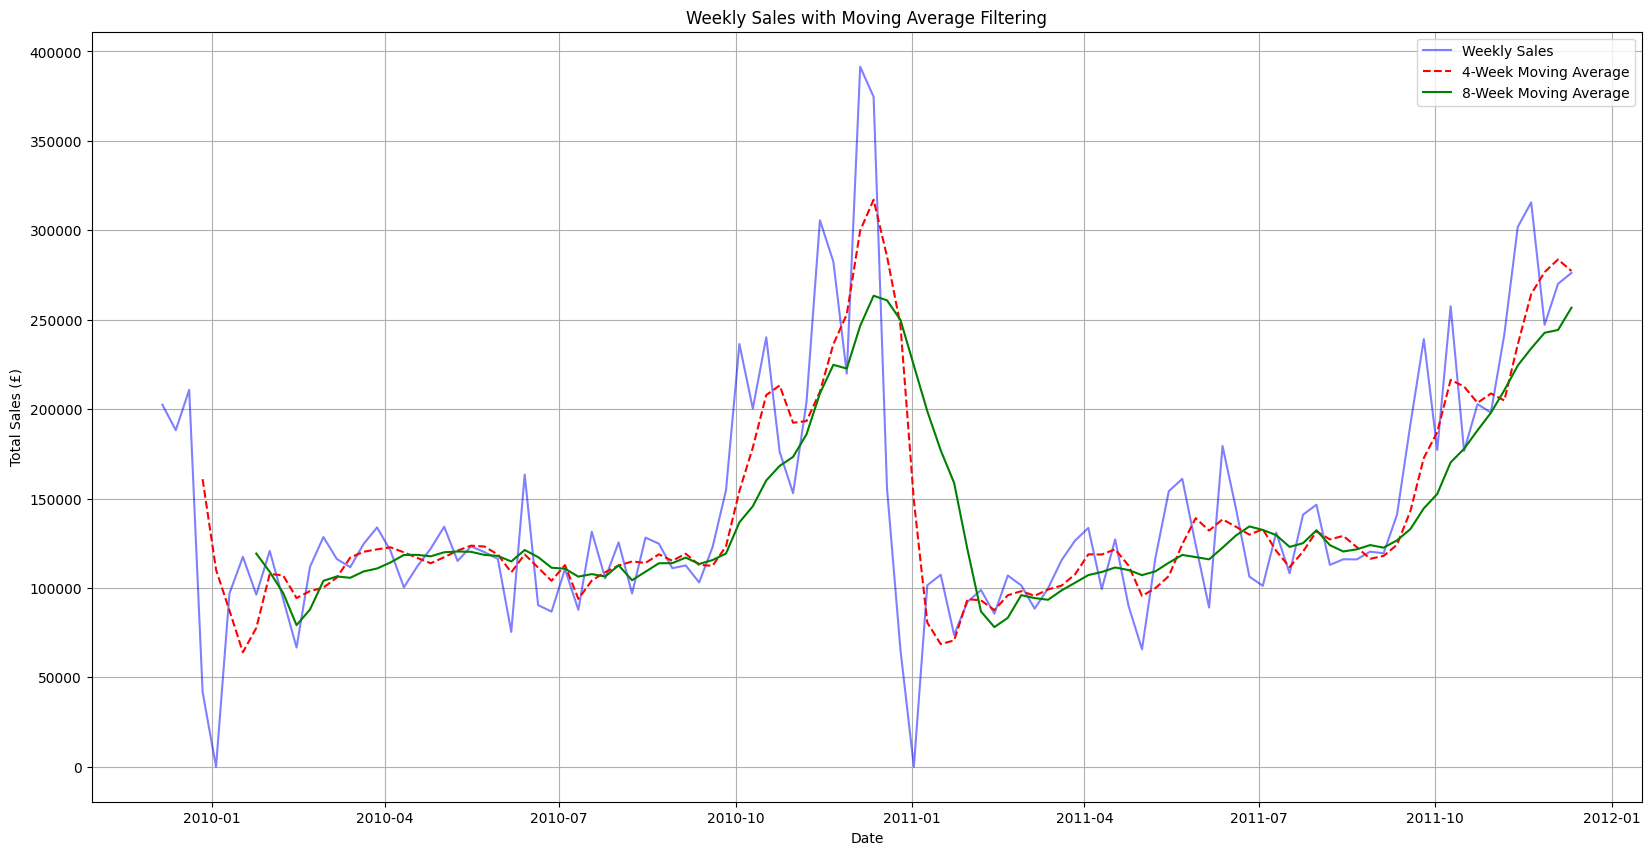

In [15]:
# === Weekly Moving average smoothing ===
ma_4 = weekly_sales.rolling(window=4).mean()
ma_8 = weekly_sales.rolling(window=8).mean()

plt.figure(figsize=(20, 10))
plt.plot(weekly_sales, color='blue', alpha=0.5, label='Weekly Sales')
plt.plot(ma_4, color='red', linestyle='dashed', label='4-Week Moving Average')
plt.plot(ma_8, color='green', linestyle='-', label='8-Week Moving Average')
plt.title('Weekly Sales with Moving Average Filtering')
plt.xlabel('Date')
plt.ylabel('Total Sales (£)')
plt.legend()
plt.grid(True)
plt.show()

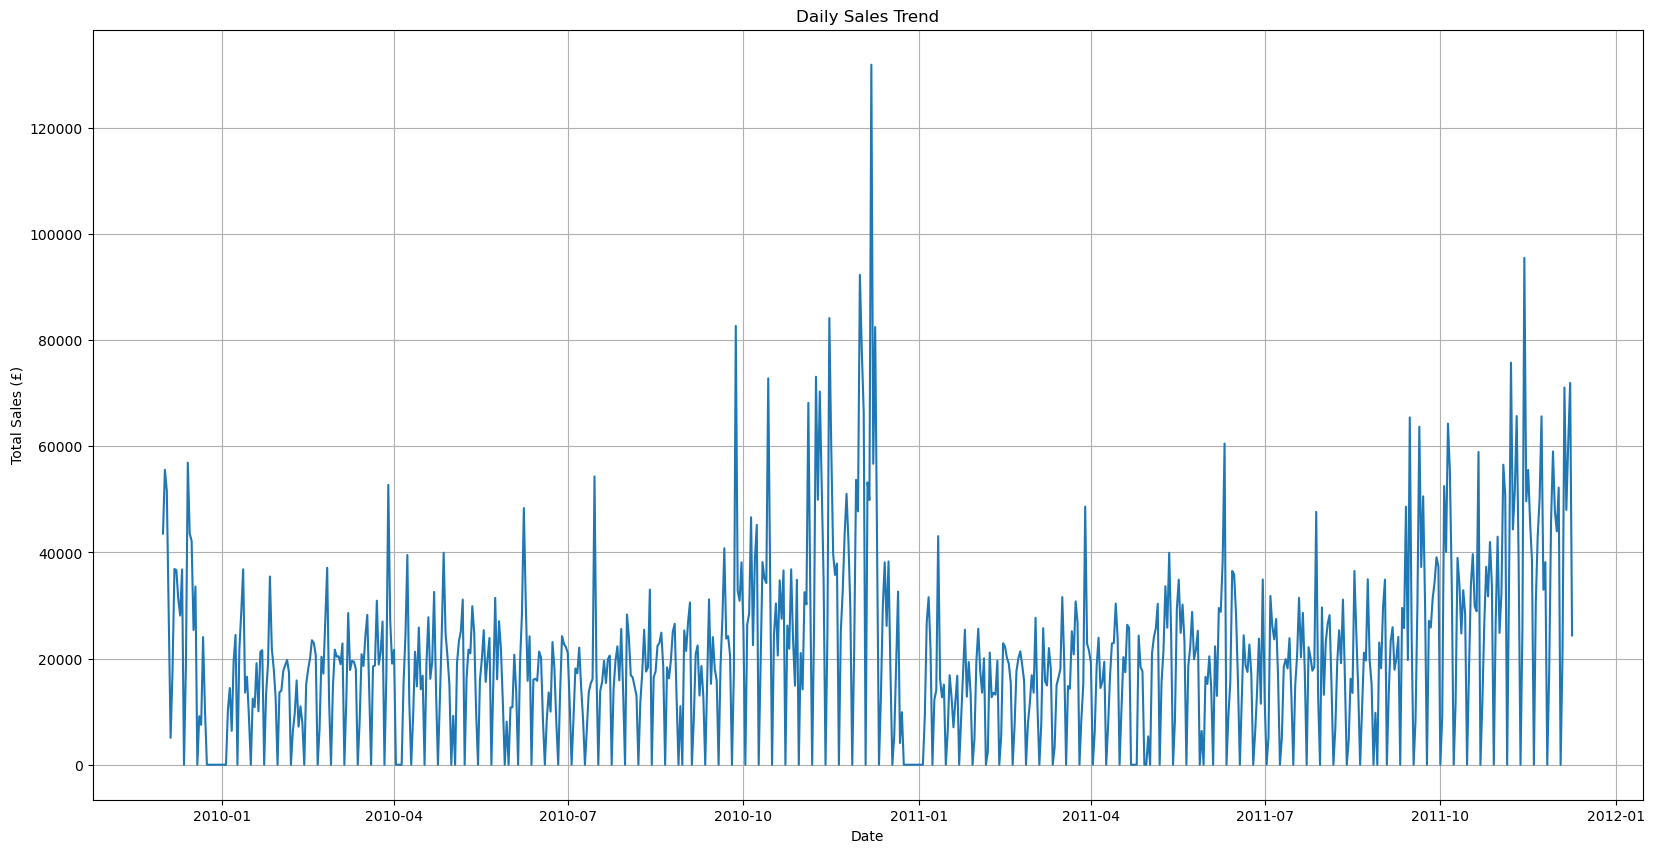

In [ ]:
# === Daily sales trend ===
daily_sales = df_cleaned.resample('D', on='InvoiceDate')['Sales'].sum()

plt.figure(figsize=(20, 10))
plt.plot(daily_sales)
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales (£)')
plt.grid(True)
plt.show()

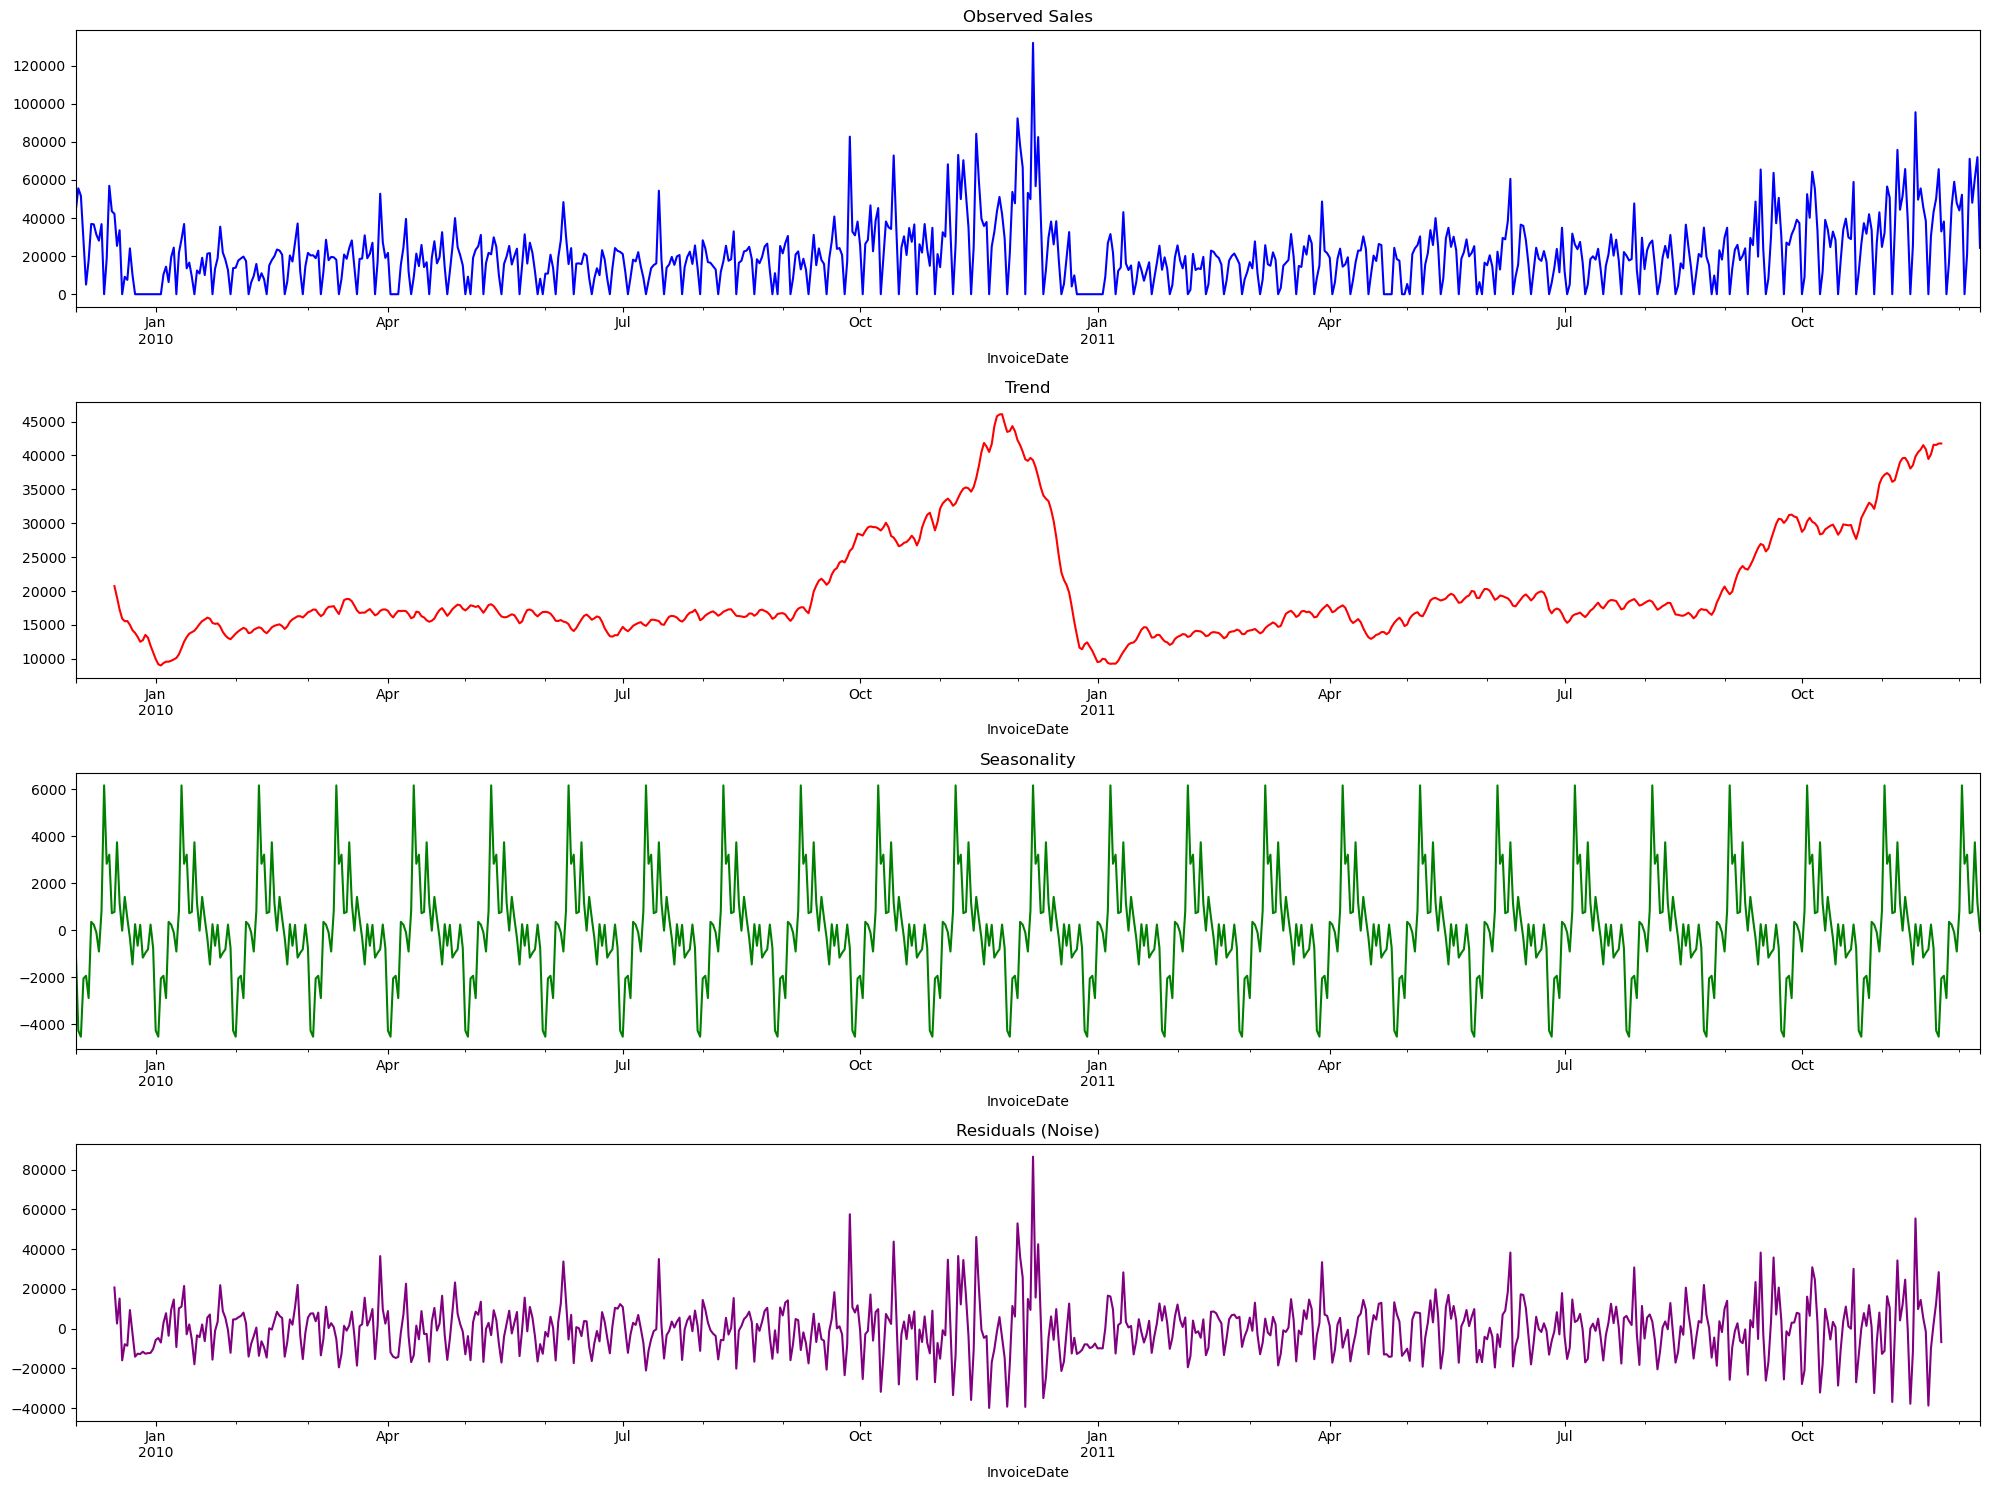

In [ ]:
# === Daily Seasonal decomposition ===
decomposed = seasonal_decompose(daily_sales, model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(20, 15))
decomposed.observed.plot(ax=axes[0], color='blue', title='Observed Sales')
decomposed.trend.plot(ax=axes[1], color='red', title='Trend')
decomposed.seasonal.plot(ax=axes[2], color='green', title='Seasonality')
decomposed.resid.plot(ax=axes[3], color='purple', title='Residuals (Noise)')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

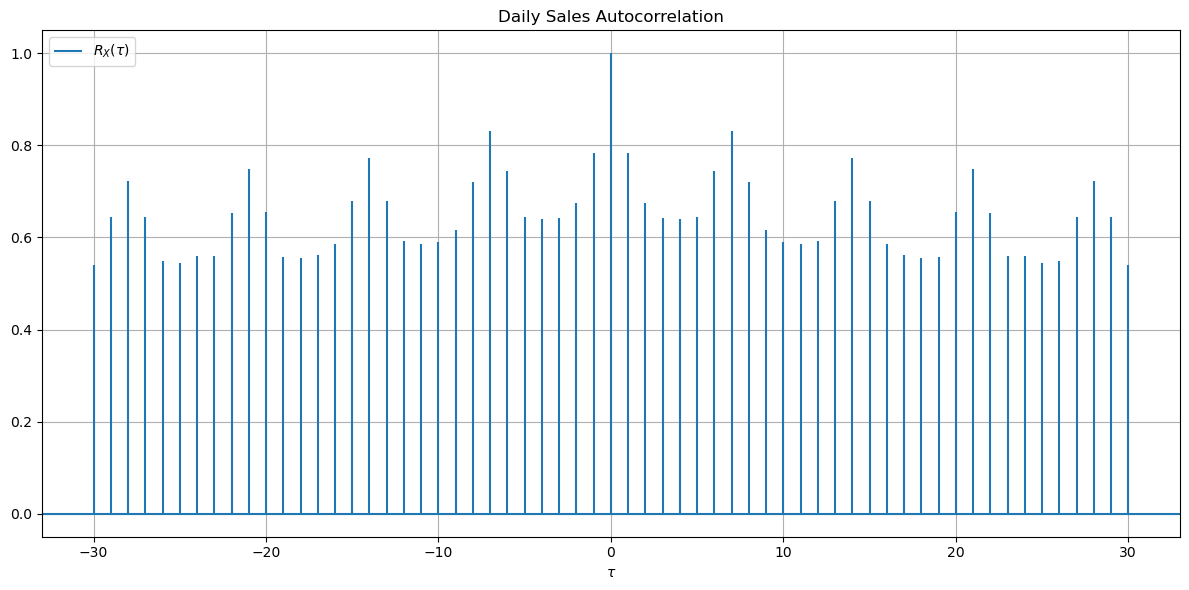

In [ ]:
# === Daily Autocorrelation plot ===
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
ax.acorr(daily_sales, maxlags=30, usevlines=True, linestyle='solid')
plt.xlabel(r'$\tau$')
plt.legend([r'$R_X(\tau)$'], loc='upper left')
plt.title('Daily Sales Autocorrelation')
ax.grid(True, which='both')
plt.tight_layout()
plt.show()

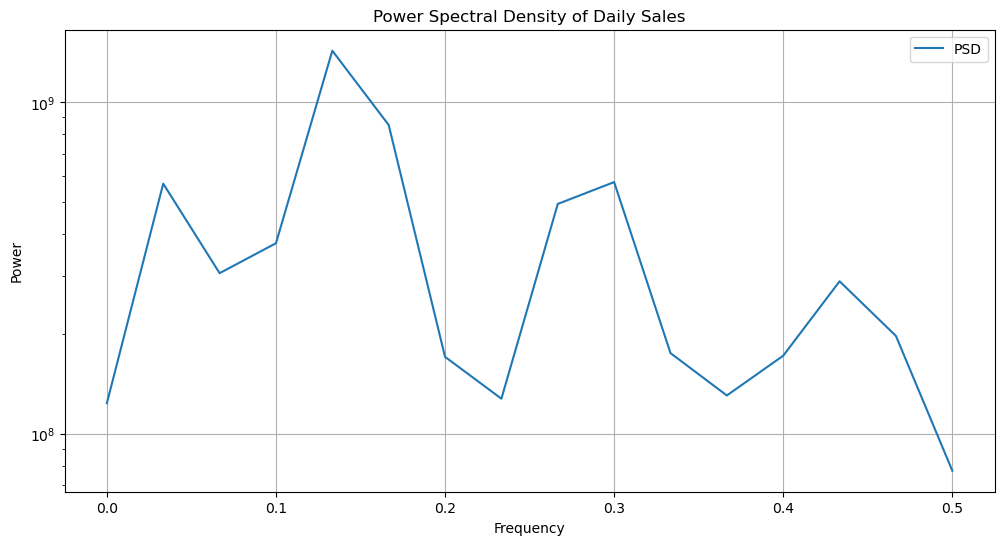

In [ ]:
# === Daily Power Spectral Density ===
freq, psd = welch(daily_sales.dropna(), nperseg=30)

plt.figure(figsize=(12, 6))
plt.semilogy(freq, psd)
plt.title("Power Spectral Density of Daily Sales")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.legend(['PSD'])
plt.show()

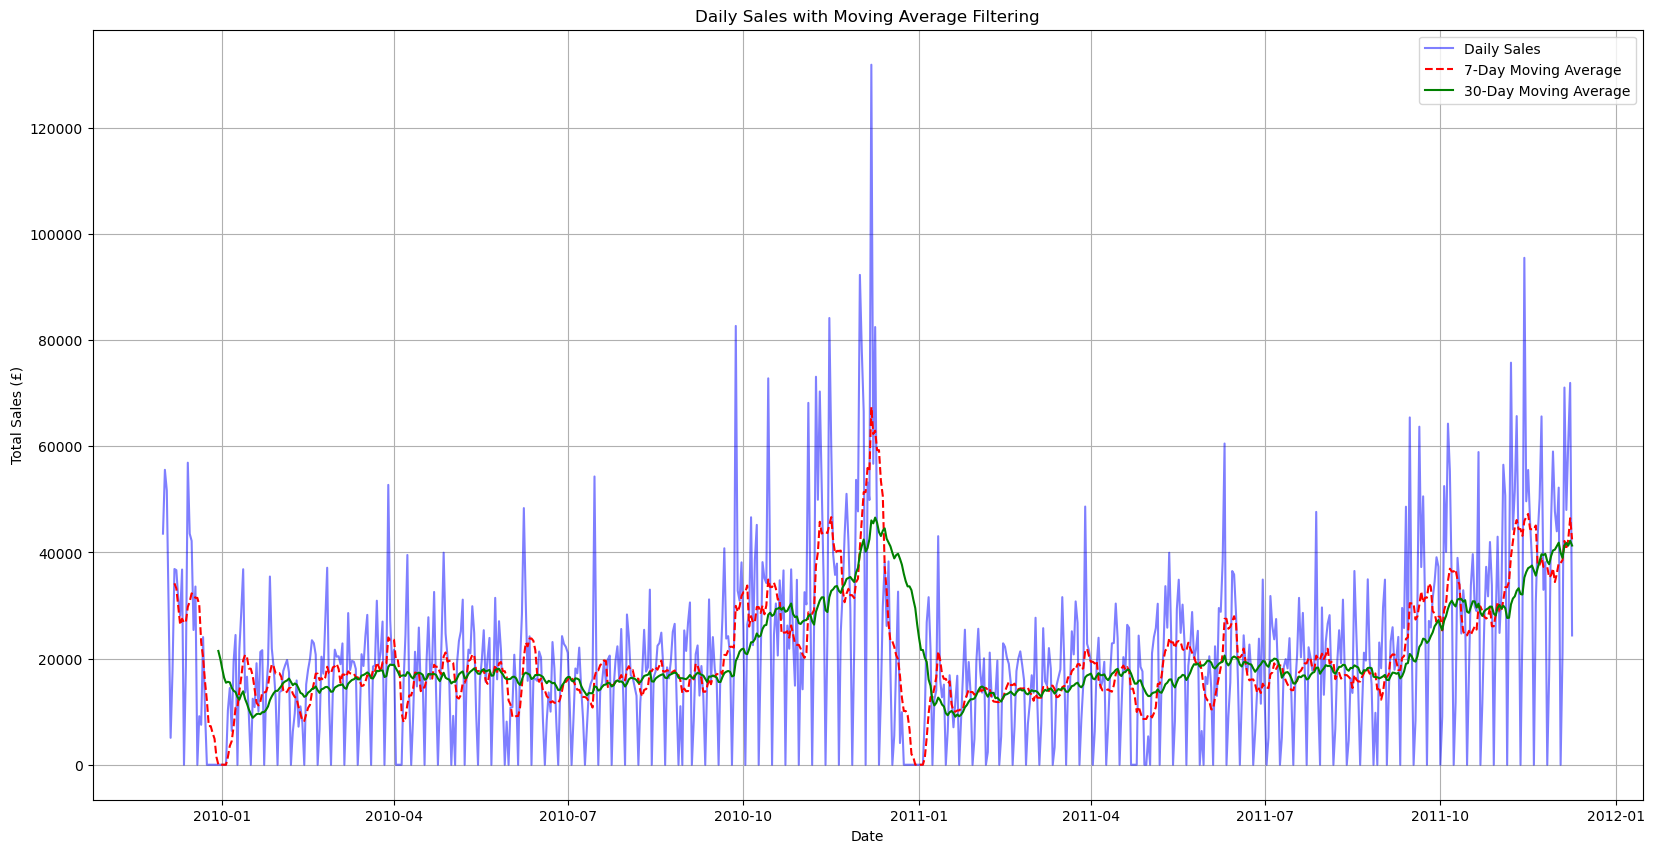

In [ ]:
# === Daily Moving average smoothing ===
rolling_mean = daily_sales.rolling(window=7).mean()
rolling_std = daily_sales.rolling(window=7).std()
ma_30 = daily_sales.rolling(window=30).mean()

plt.figure(figsize=(20, 10))
plt.plot(daily_sales, color='blue', alpha=0.5, label='Daily Sales')
plt.plot(rolling_mean, color='red', linestyle='dashed', label='7-Day Moving Average')
plt.plot(ma_30, color='green', linestyle='-', label='30-Day Moving Average')
plt.title('Daily Sales with Moving Average Filtering')
plt.xlabel('Date')
plt.ylabel('Total Sales (£)')
plt.legend()
plt.grid(True)
plt.show()

### outlier detection

In [ ]:
threshold = 3  # z-score threshold
rolling_mean = daily_sales.rolling(window=7).mean()
rolling_std = daily_sales.rolling(window=7).std()

# Identify outliers where daily sales deviate > 3 std from rolling mean
outliers = daily_sales[
    (daily_sales - rolling_mean).abs() > threshold * rolling_std
]

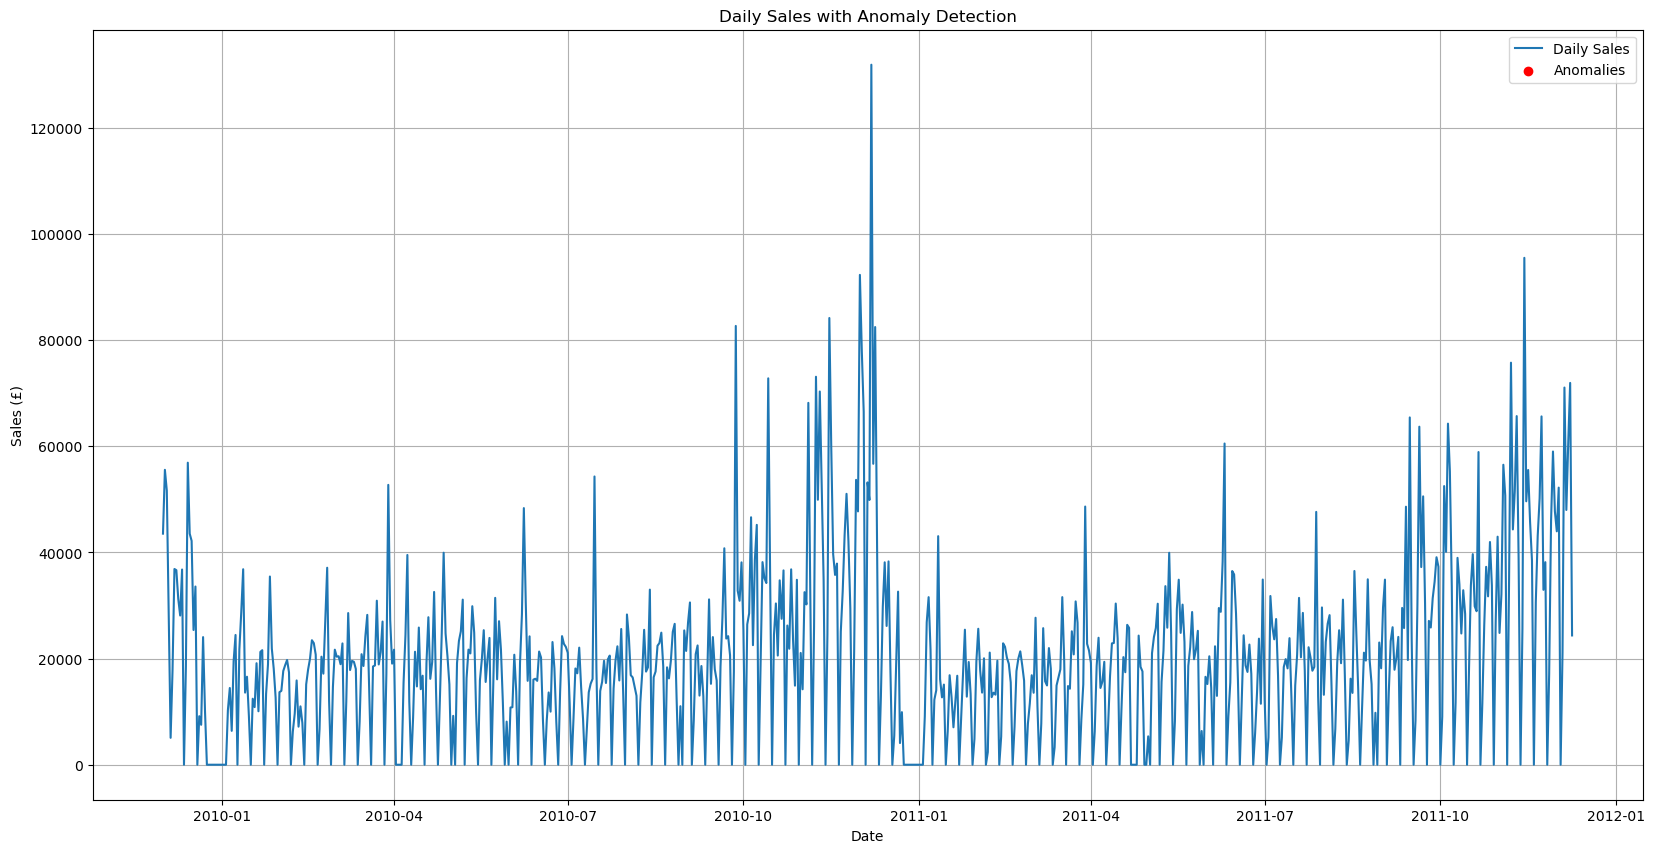

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(daily_sales, label='Daily Sales')
plt.scatter(outliers.index, outliers.values, color='red', label='Anomalies')
plt.title('Daily Sales with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Sales (£)')
plt.legend()
plt.grid(True)
plt.show()

# no anomalies

In [19]:
threshold = 3  # z-score threshold
rolling_mean = weekly_sales.rolling(window=4).mean()
rolling_std = weekly_sales.rolling(window=4).std()

# Identify outliers where daily sales deviate > 3 std from rolling mean
outliers = weekly_sales[
    (weekly_sales - rolling_mean).abs() > threshold * rolling_std
]

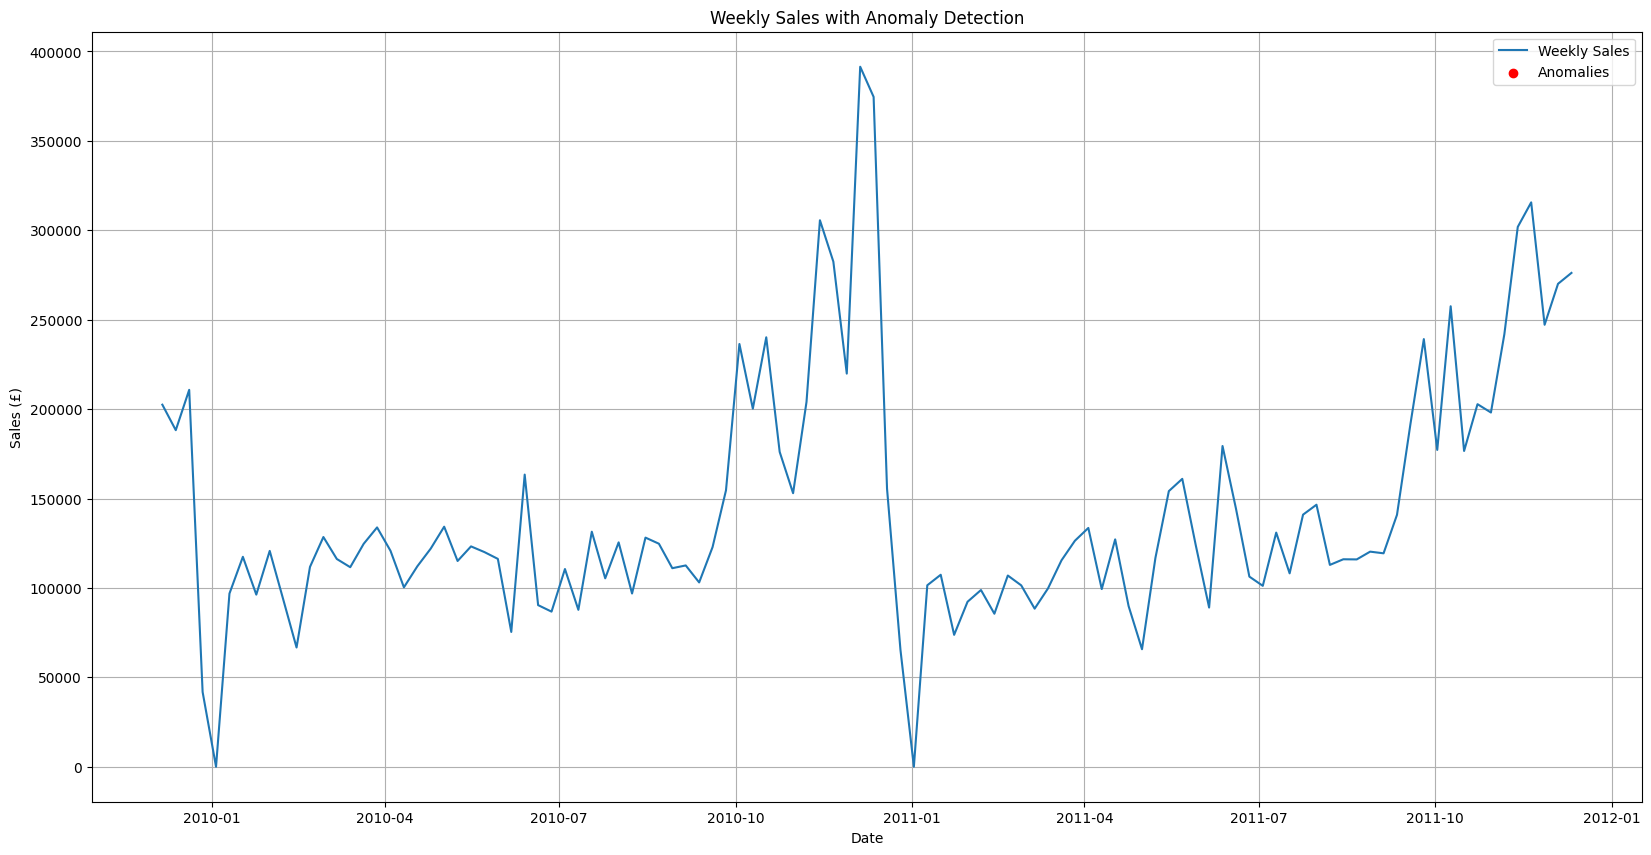

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(weekly_sales, label='Weekly Sales')
plt.scatter(outliers.index, outliers.values, color='red', label='Anomalies')
plt.title('Weekly Sales with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Sales (£)')
plt.legend()
plt.grid(True)
plt.show()

# no anomalies

### check holiday

In [ ]:
# !pip install holidays

In [ ]:
import holidays

# build holiday mapping (UK)
uk_holidays = holidays.UnitedKingdom(years=range(2009, 2012))
for date, name in (uk_holidays.items()):
    print(f"{date}: {name}")

2009-04-10: Good Friday
2009-05-04: May Day
2009-05-25: Spring Bank Holiday
2009-01-01: New Year's Day
2009-12-25: Christmas Day
2009-12-26: Boxing Day
2009-12-28: Boxing Day (observed)
2010-04-02: Good Friday
2010-05-03: May Day
2010-05-31: Spring Bank Holiday
2010-01-01: New Year's Day
2010-12-25: Christmas Day
2010-12-27: Christmas Day (observed)
2010-12-26: Boxing Day
2010-12-28: Boxing Day (observed)
2011-04-22: Good Friday
2011-05-02: May Day
2011-05-30: Spring Bank Holiday
2011-04-29: Wedding of William and Catherine
2011-01-01: New Year's Day
2011-01-03: New Year's Day (observed)
2011-12-25: Christmas Day
2011-12-27: Christmas Day (observed)
2011-12-26: Boxing Day


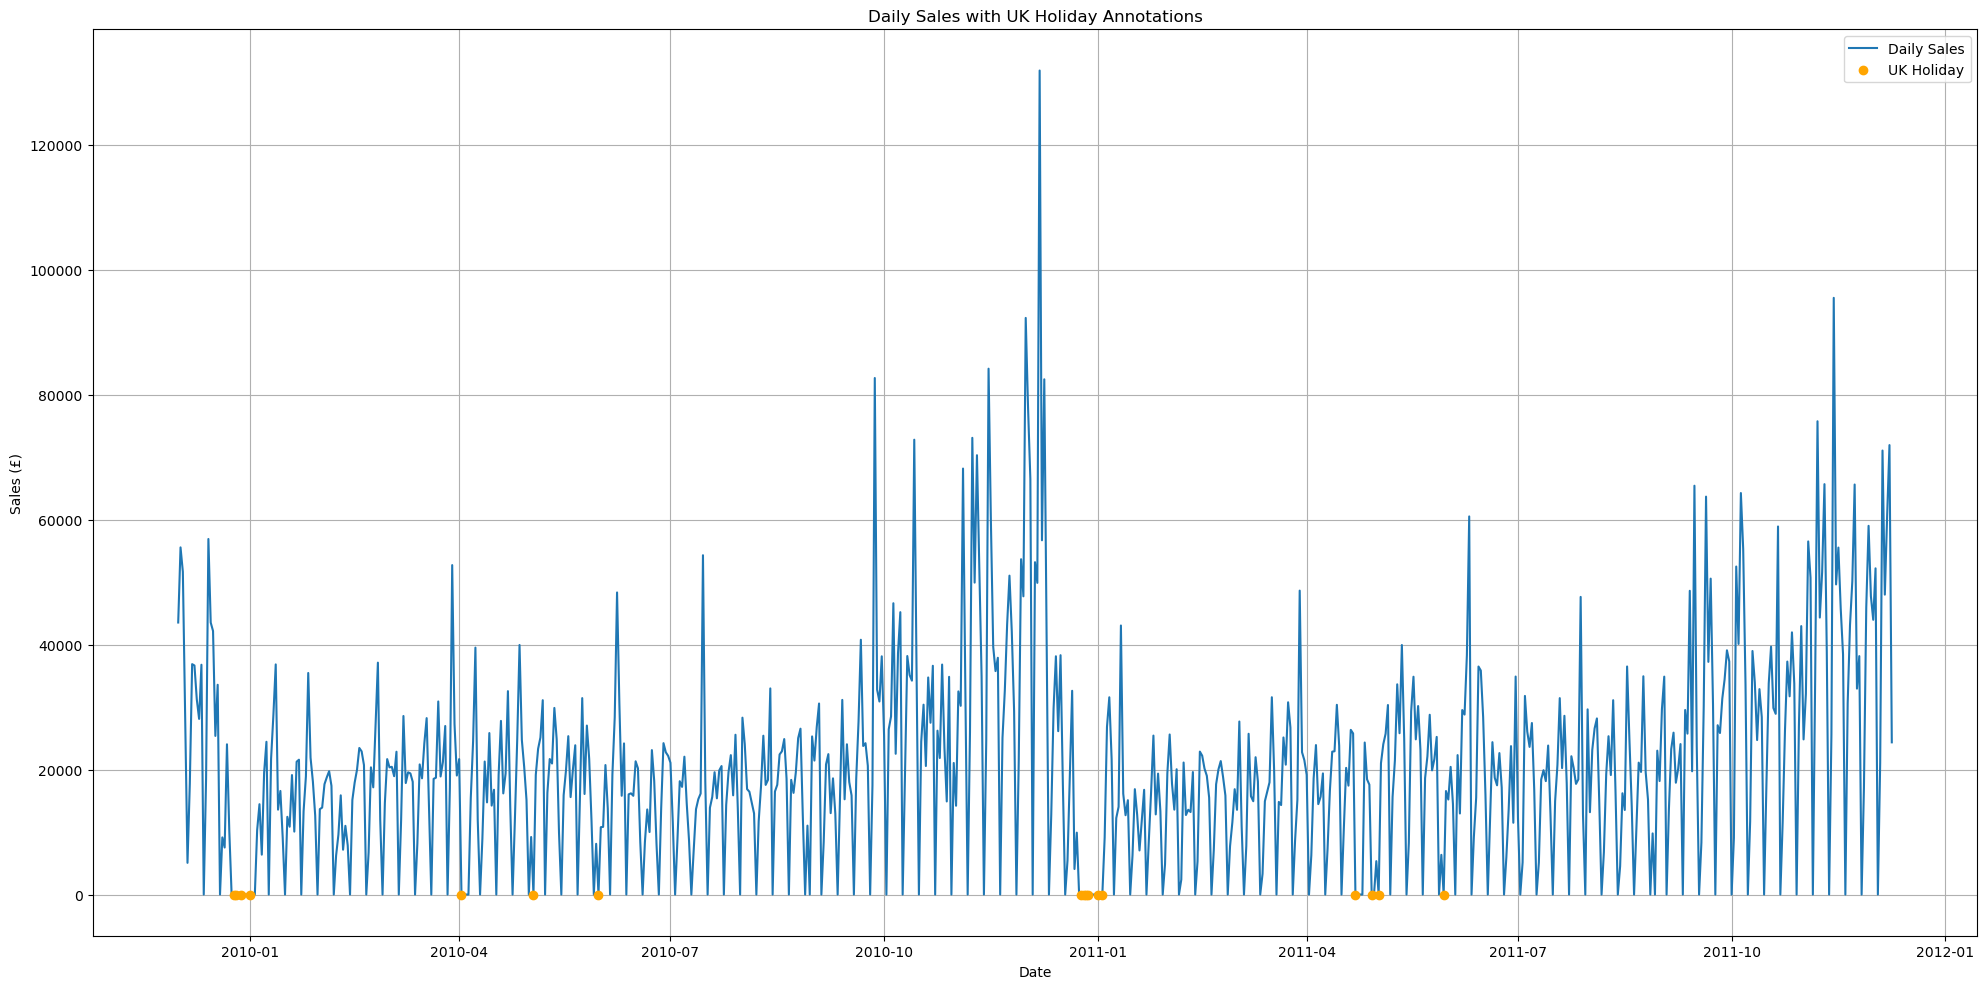

In [ ]:
# Create holiday flag column
daily_sales_flagged = daily_sales.to_frame(name='Sales')
daily_sales_flagged['Holiday'] = daily_sales_flagged.index.to_series().apply(lambda d: d in uk_holidays)

# plot with holiday points
plt.figure(figsize=(20, 10))
plt.plot(daily_sales_flagged.index, daily_sales_flagged['Sales'], label='Daily Sales')
plt.scatter(
    daily_sales_flagged[daily_sales_flagged['Holiday']].index,
    daily_sales_flagged[daily_sales_flagged['Holiday']]['Sales'],
    color='orange', label='UK Holiday', zorder=3
)
plt.title('Daily Sales with UK Holiday Annotations')
plt.xlabel('Date')
plt.ylabel('Sales (£)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()